In [1]:
#!mkdir save_model save_graph

In [2]:
import sys
import pylab
import random
import numpy as np
from collections import deque
import environment

import torch
from torch import nn, optim
import torch.nn.functional as F

In [3]:
# 최대로 실행할 에피소드 수를 설정합니다.
EPISODES = 2000

In [4]:
# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        '''
        구글 colab에서는 아래 render를 True로 만들면 실행이 안됩니다.
        '''
        self.render = True

        '''
        저장해 놓은 신경망 모델을 가져올 지 선택합니다. (mountaincar_trainded.h5)
        훈련을 중간에 중단해 놓았다가 다시 시작하려면 아래를 True로 바꾸고 실행하시면 됩니다.
        '''
        self.load_model = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        '''
        일단 None이라고 되어있는 부분 위주로 수정해주세요. (다른 것들 잘못 건드시면 안될수도 있음)
        아래 8개 하이퍼파라미터(maxlen 포함)는 cartpole_dqn 예제 그대로 복사하셔도 되고, 좀 수정하셔도 됩니다.
        '''
        self.discount_factor = 0.99
        self.learning_rate = 0.01
        self.epsilon = 1.0
        self.epsilon_decay = 0.95
        self.epsilon_min = 0.10
        self.batch_size = 64
        self.train_start = 5000

        # 리플레이 메모리, 최대 크기 10000
        self.memory = deque(maxlen=10000)

        self.action_buffer = []
        
        # 모델과 타깃 모델 생성
        '''
        아마 그냥 실행하시면 오류가 날텐데
        build_model을 완성하시면 오류가 사라집니다.
        '''
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

        if self.load_model:
            self.model.load_state_dict(torch.load(
                './save_model/mountaincar_dqn_success.bin'))

    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.action_size),
        )
        
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        # 버퍼에 남으면 버퍼 수행
        if len(self.action_buffer) > 0:
            return [[self.action_buffer.pop()]]

        # 휴리스틱 가능하면 휴리스틱
        buffer = env.try_to_kill()
        if buffer:
            self.action_buffer = buffer
            return [[self.action_buffer.pop()]]
        
        # 아니면 DQN
        legal_actions = env.legal_actions()
        if np.random.rand() <= self.epsilon:
            # 무작위 행동 반환
            return [[random.choice(legal_actions)]]
        else:
            # 모델로부터 행동 산출
            return self.model(state).data.max(1)[1].view(1, 1) #FIXME: 이거 어케하지

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        reward = torch.FloatTensor([reward])
        next_state = torch.FloatTensor([next_state])
        done = torch.FloatTensor([done])

        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        dones = torch.cat(dones)

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        current_q = self.model(states).gather(1, actions)
        max_next_q = self.target_model(next_states).detach().max(1)[0]
        expected_q = rewards + (self.discount_factor * max_next_q)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        self.optimizer.zero_grad()

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        loss.backward()

        self.optimizer.step()


In [5]:
from requests import get

In [6]:
try:
    del env
except:
    pass
env = environment.Environment()

state_size = env.map.size
action_size = env.legal_actions().__len__()

agent = DQNAgent(state_size, action_size)

scores, episodes, epsilons, max_poss = [], [], [], []

ip = get('http://api.ipify.org').text
env.start(ip=ip)

ip: 125.137.27.125
session create..done!


join..done!
game start..done!
s.!s.!s.!v.!v.!v.!v.!s.!s.!114554 -> move south
s.!s.!s.!v.!v.!v.!v.!s.!s.!114554 -> move south
s.!s.!s.!v.!v.!v.!v.!s.!s.!114554 -> move east
s.!s.!s.!v.!v.!v.!v.!assertion i, j 10 31
s.!s.!114554 -> rotate +45
s.!s.!s.!v.!v.!v.!v.!assertion i, j 10 31
s.!s.!114554 -> move east
s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
assertion i, j 9 31
assertion i, j 10 31
s.!s.!114554 -> rotate +45
s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
assertion i, j 9 31
assertion i, j 10 31
s.!s.!114554 -> turn end

s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
assertion i, j 9 31
assertion i, j 10 31
s.!s.!114571 -> attack
s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
assertion i, j 9 31
assertion i, j 10 31
s.!s.!114571 -> move south
s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
assertion i, j 9 31
assertion i, j 10 31
s.!s.!114571 -> turn end

s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
assertion i, j 9 31
assertion i, j 10 31
s.!s.!114588 -> move north
s.!s.!s.!v.!v.!v.!v.!assertion i, j 8 31
a

ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

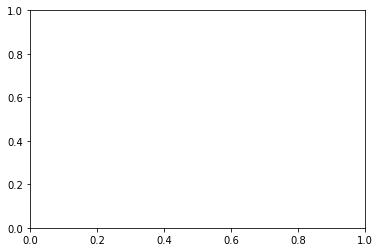

In [7]:
for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    
    while not done:
        # env.render()
        
        state = torch.FloatTensor(state)
        action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        agent.append_sample(state, action, reward, next_state, done)
        
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
        
        score += reward
        state = next_state
        
        if done:
            agent.update_target_model()
            
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./save_graph/tank_dqn.png")
            
            print(f"episode: {e} | score: {score:.5f} | memory length: {len(agent.memory)} | epsilon: {agent.epsilon:.5f}")
            
            print(info)
            print('\n','*'*30,'\n')
            
            torch.save(agent.model.state_dict(),
                        f"./save_model/lunarlander_dqn_{e}.bin")
    
    if len(agent.memory) >= agent.train_start and agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay